In [1]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram
from mne.viz import plot_topomap
from scipy.signal import welch
import matplotlib.pyplot as plt

Preproccesing Functions

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    # df_new = z_score(df_new, col_names)
    # df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 5
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.001 
    df[channel] = interpolated_values
    return df

# def reject_spikes_epochs(df, channel):
#     """Detects spikes in the specified channel of a DataFrame."""
#     threshold_factor = 3
#     median = df[channel].median()
#     mad = np.median(np.abs(df[channel] - median))
#     return np.abs(df[channel] - median) > threshold_factor * mad

def plot_eeg_data(before, after, title, colors):
    """Plots EEG data."""
    plt.figure(figsize=(12, 8))
    for i in range(before.shape[1]):
        plt.plot(before[:, i] + i * 200, color=colors[i])  # Offset added for visualization clarity
    for i in range(after.shape[1]):
        plt.plot(after[:, i] + i * 200, color=colors[i], linestyle='--')
    plt.title(title)
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.show()


Define the dataset

In [4]:
montage = mne.channels.make_standard_montage('standard_1020')

In [5]:
# Creating a new folder for spike rejected data
new_folder = 'spike_rejected_data'
if not os.path.exists(new_folder):
    os.makedirs(new_folder)    
folder_name = 'ES_1'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

def detect_spikes(df, channel):
    """Detects spikes in the specified channel of a DataFrame."""
    threshold_factor = 5
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    return np.abs(df[channel] - median) > threshold_factor * mad

# Creating a new subfolder within folder_name for spike rejected data
new_folder_path = os.path.join(folder_name, 'spike_rejected_data')
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

sampling_rate = 250
epoch_length=sampling_rate
BP=[]
PP=[]
B=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            df_temp = s_temp.iloc[:, :8]
            inst= s_temp.iloc[:, 17]
            
            # Band Pass Filtering
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250)

            # 2. Artifact rejection
            BP_artifact_RJ = np.copy(raw_bp)
            for channel in range (8):
                BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
                
            # 4. Denoising and other preprocessing
            BP_artifact_RJ.columns = selected_columns
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[10]*len(selected_columns))
            eeg_df_denoised.plot(subplots=True, figsize=(15, 10), title=f"Denoised EEG Data_{ file_name}")
            plt.show()

            # Detecting Spikes and Epoching
            # spike_records = {channel: detect_spikes(eeg_df_denoised, channel) for channel in selected_columns}
            # Detecting Spikes
            spike_records = {}
            for channel in selected_columns:
                spikes = detect_spikes(eeg_df_denoised, channel)
                spike_records[channel] = np.where(spikes)[0]
            print(spike_records)
            clean_epochs = []
            clean_inst = []
            for j in range(0, eeg_df_denoised.shape[0], epoch_length):
                epoch = eeg_df_denoised.iloc[j:j + epoch_length]
                inst_epoch = inst[j:j + epoch_length]
                if not any(epoch.index.isin(np.hstack(list(spike_records.values())))):
                    clean_epochs.append(epoch)
                    clean_inst.append(inst_epoch)

            # Concatenating Cleaned Data
            if clean_epochs:
                cleaned_data = pd.concat(clean_epochs, ignore_index=True)
                cleaned_inst = pd.concat(clean_inst, ignore_index=True)
                cleaned_data['Inst'] = cleaned_inst  # Add the instruction/label column
                cleaned_data.plot(subplots=True, figsize=(15, 10), title=f"Spike Removed EEG Data_{file_name}")
                plt.show()

                # Save the cleaned data to a new CSV file
                cleaned_file_path = os.path.join(new_folder_path, f'{file_name}_spike_reject.csv')
                cleaned_data.to_csv(cleaned_file_path, index=False)
                print(cleaned_data.shape)
            else:
                print(f"No clean epochs found for file {file_name}. Skipping plotting.")


In [41]:
folder_name = 'ES_1'
subfolder_name = 'spike_rejected_data'  # Name of the subfolder with spike-rejected data
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink', 'brown', 'gray']

# Full path to the subfolder
spike_rejected_folder = os.path.join(folder_name, subfolder_name)
duration = 40 
EEG_Before_ICA=[]
event=[]
totaldata=[]
if os.path.exists(spike_rejected_folder) and os.path.isdir(spike_rejected_folder):
    for file_name in os.listdir(spike_rejected_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(spike_rejected_folder, file_name)
            s_temp = pd.read_csv(file_path, header=0)
            # print(s_temp.shape)
            totaldata.append(s_temp)
            
            instruction = s_temp.iloc[:, 8]
            df_temp = s_temp.iloc[:, :8]

            EEG_Before_ICA.append(df_temp)
            event.append(instruction ) 
            

In [47]:
import numpy as np
base = []
face = []
scene = []

for block in totaldata:
    labels = block.iloc[:, -1]  # Extract labels
    base_data = block[labels.isin(['g', 'b'])].iloc[:, :8]  # Exclude label column
    face_data = block[labels.isin(['F', 'M'])].iloc[:, :8]
    scene_data = block[labels.isin(['I', 'O'])].iloc[:, :8]

    # Append to corresponding lists
    base.append(base_data)
    face.append(face_data)
    scene.append(scene_data)

# Convert lists to numpy arrays
base_array = np.vstack(base)
face_array = np.vstack(face)
scene_array = np.vstack(scene)

In [63]:
face_data_without_c4 = np.delete(face_array, 5, axis=1)
scene_data_without_c4 = np.delete(face_array, 5, axis=1)
base_data_without_c4 = np.delete(face_array, 5, axis=1)

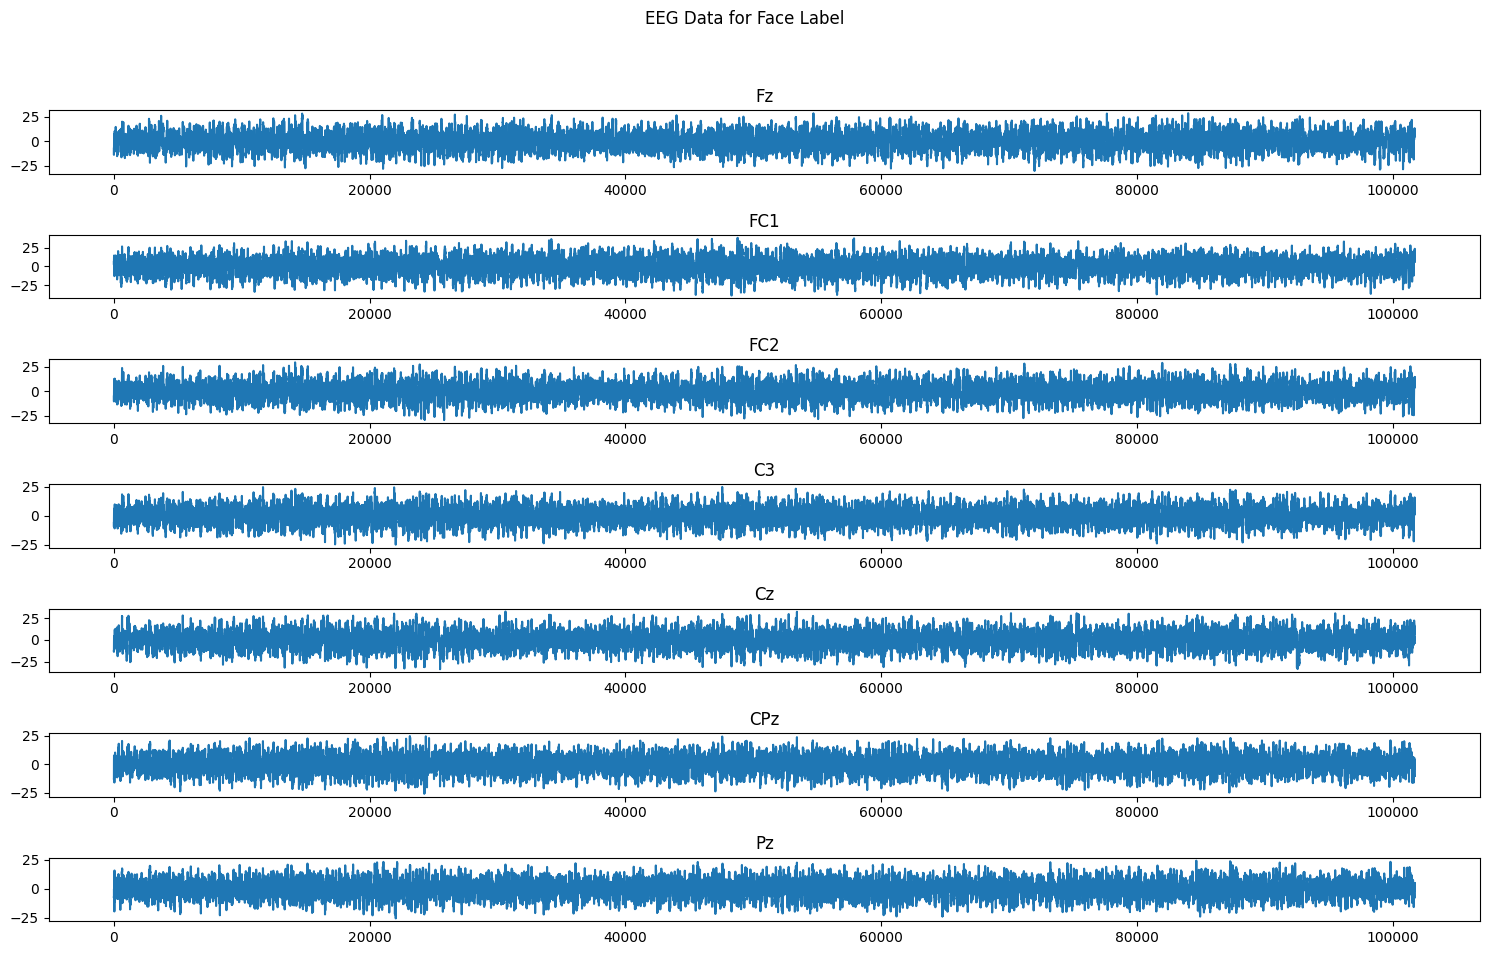

In [68]:
import matplotlib.pyplot as plt

# Assuming face_array is a NumPy array with shape (n_samples, n_channels)
# And the channel names are given in selected_columns
selected_columns_without_c4 = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'CPz', 'Pz']

plt.figure(figsize=(15, 10))
n_channels = base_data_without_c4.shape[1]

# Creating a subplot for each channel
for i in range(n_channels):
    ax = plt.subplot(n_channels, 1, i + 1)
    ax.plot(base_data_without_c4[:, i])
    ax.set_title(selected_columns_without_c4[i])  # Set the title to the channel name

plt.suptitle("EEG Data for Face Label")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout for subplot titles and main title
plt.show()


In [102]:
# Calculate the mean of the baseline data
baseline_mean = np.mean(base_data_without_c4, axis=0)

# Subtract the baseline mean from the face and scene data
baseline_rejected_face = face_data_without_c4 
baseline_rejected_scene = scene_data_without_c4 


In [103]:
def mean_epoch(data, epoch_length):
    # Number of epochs
    n_epochs = data.shape[0] // epoch_length
    # Reshape data into epochs
    epochs = data[:n_epochs * epoch_length].reshape(n_epochs, epoch_length, -1)
    # Compute the mean of all epochs
    mean_epoch = np.mean(epochs, axis=0)
    return mean_epoch

epoch_length = 250





# Applying the function to each array
face_mean_epoch = mean_epoch(baseline_rejected_face, epoch_length)
scene_mean_epoch = mean_epoch(baseline_rejected_scene, epoch_length)
base_mean_epoch = mean_epoch(base_data_without_c4, epoch_length)


In [104]:
face_mean_reshape=face_mean_epoch.reshape(7,250)
scene_mean_reshape=scene_mean_epoch.reshape(7,250)
base_mean_reshape=base_mean_epoch.reshape(7,250)

In [105]:
# epoching
face_epochs = baseline_rejected_face.reshape(7, 250,int(baseline_rejected_face.shape[0]/250) )
scene_epochs = baseline_rejected_scene.reshape(7, 250,int(baseline_rejected_scene.shape[0]/250) )
base_epochs = base_data_without_c4.reshape(7, 250,int(base_data_without_c4.shape[0]/250) )


In [106]:
# Calculate the sampling interval
sampling_interval = 1 / 250  # Sampling rate of 250Hz equals a sampling interval of 0.004 seconds or 4 milliseconds
# Generate the time points from 0 to 42000 milliseconds
times = np.arange(0, 1, step=sampling_interval)
# Convert the times array to milliseconds from seconds
times = times * 1000  # Convert from seconds to milliseconds
times[:10]  # Show the first 10 time points to verify


array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36.])

In [107]:
import pandas as pd
# Convert the first block to a DataFrame
df = pd.DataFrame(face_mean_epoch)
# Save the DataFrame to a CSV file
csv_filename = 'face_mean_epoch.csv'
df.to_csv(csv_filename, index=False)
csv_filename

'face_mean_epoch.csv'

In [92]:
def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]

    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

# Function to calculate power for variable or fixed cycles
def calculate_power(cycles):
    power_matrix = []
    for freq, cycle in zip(frequencies, cycles):
        data_fcz = face_epochs[3]  # Assuming trials are on the second dimension
        # Calculate power for each trial
        power_trials = []
        for trial_idx in range(data_fcz.shape[1]):
            trial_2D = data_fcz[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            power = np.abs(convolution)**2
            power_trials.append(power[0])
        # Average power across trials
        avg_power = np.mean(power_trials, axis=0)
        power_matrix.append(avg_power)
    return np.array(power_matrix)

def calculate_power_baseline(cycles):
    power_matrix_baseline = []
    for freq, cycle in zip(frequencies, cycles):
        data_fcz = base_epochs[3]  # Assuming trials are on the second dimension
        # Calculate power for each trial
        power_trials = []
        for trial_idx in range(data_fcz.shape[1]):
            trial_2D = data_fcz[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            power = np.abs(convolution)**2
            power_trials.append(power[0])
        # Average power across trials
        avg_power = np.mean(power_trials, axis=0)
        power_matrix_baseline.append(avg_power)
    return np.array(power_matrix_baseline)

# Baseline correction function
def baseline_correction(power_matrix, power_matrix_baseline):
    return power_matrix/power_matrix_baseline  # Division for baseline correction

# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(1, 10, len(frequencies))  # Variable cycles from 3 to 10
sampling_rate=250

# Calculate power for variable and fixed cycles
power_variable_cycles = calculate_power(cycles)
power_baseline_variable_cycles = calculate_power_baseline(cycles)

# Apply baseline correction
corrected_variable = baseline_correction(power_variable_cycles,power_baseline_variable_cycles )



In [112]:
import numpy as np

def morlet_wavelet(frequency, num_cycles, sampling_rate, duration=2):
    t = np.linspace(-duration/2, duration/2, int(sampling_rate * duration), endpoint=False)
    sine_wave = np.exp(2j * np.pi * frequency * t)
    amplitude_envelope = np.exp(-t**2 * (np.pi * frequency / num_cycles)**2)
    wavelet = sine_wave * amplitude_envelope
    return wavelet

def convolve_with_wavelet(data, wavelet):
    n_signal = data.shape[1]
    n_wavelet = len(wavelet)
    n_convolution = n_signal + n_wavelet - 1

    data_fft = np.fft.fft(data, n_convolution, axis=1)
    wavelet_fft = np.fft.fft(wavelet, n_convolution)[np.newaxis, :]

    convolution_result_fft = data_fft * wavelet_fft
    convolution_result = np.fft.ifft(convolution_result_fft, axis=1)

    # Cut the data
    start = (n_wavelet - 1) // 2
    end = start + n_signal
    return convolution_result[:, start:end]

def calculate_power(data_epochs, cycles, sampling_rate):
    power_matrix = []
    for freq, cycle in zip(frequencies, cycles):
        # Extract data for the fourth channel (index 3)
        data_fcz = data_epochs[3]  # This extracts the fourth channel data for all trials

        # Calculate power for each trial
        power_trials = []
        for trial_idx in range(data_fcz.shape[1]):
            trial_2D = data_fcz[:, trial_idx].reshape(1, -1)  # Making trial 2D for the convolution function
            wavelet = morlet_wavelet(freq, cycle, sampling_rate)
            convolution = convolve_with_wavelet(trial_2D, wavelet)
            power = np.abs(convolution)**2
            power_trials.append(power[0])

        # Average power across trials
        avg_power = np.mean(power_trials, axis=0)
        power_matrix.append(avg_power)
    return np.array(power_matrix)

# Baseline correction function
def baseline_correction(power_matrix, power_matrix_baseline):
    return power_matrix / power_matrix_baseline  # Division for baseline correction

# Constants
frequencies = np.arange(0, 40, 2)  # 0 to 40 Hz
cycles = np.linspace(3, 10, len(frequencies))  # Variable cycles from 1 to 10
sampling_rate = 250

# Assuming face_epochs, scene_epochs, and base_epochs are defined and have the correct shape
power_variable_cycles_face = calculate_power(face_epochs, cycles, sampling_rate)
power_variable_cycles_scene = calculate_power(scene_epochs, cycles, sampling_rate)
power_baseline_variable_cycles = calculate_power(base_epochs, cycles, sampling_rate)

# Apply baseline correction
corrected_variable_face = baseline_correction(power_variable_cycles_face, power_baseline_variable_cycles)
corrected_variable_scene = baseline_correction(power_variable_cycles_scene, power_baseline_variable_cycles)


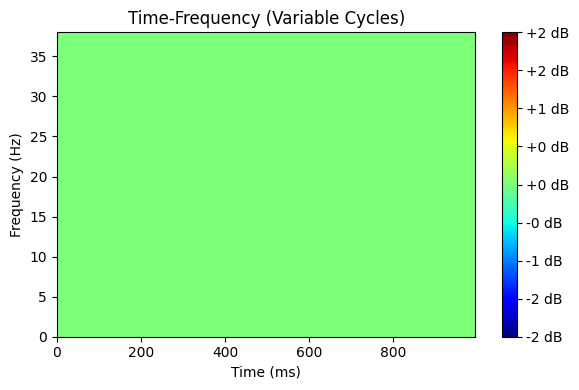

In [113]:
# Plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(100* np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[0], times[249], frequencies[0], frequencies[-1]],
               vmin=-2, vmax=2)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()
# Plot the results
plot_time_frequency(corrected_variable_scene , 'Time-Frequency (Variable Cycles)')


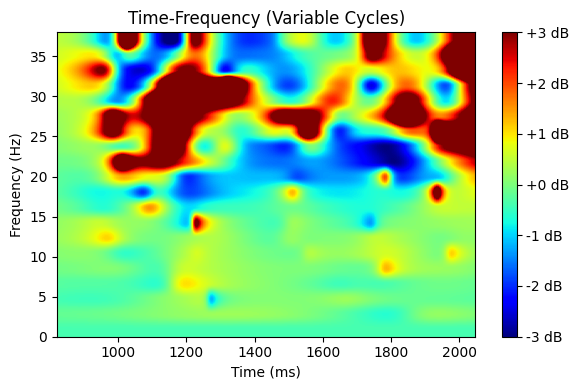

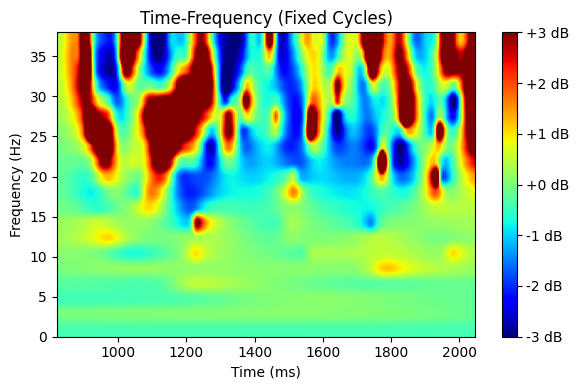

In [199]:
# Plotting function
def plot_time_frequency(data, title):
    plt.figure(figsize=(6, 4))
    plt.imshow(10 * np.log10(data), aspect='auto', cmap='jet', origin='lower',
               extent=[times[205], times[512], frequencies[0], frequencies[-1]],
               vmin=-3, vmax=3)  # Log transform of power; color limits as specified
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (ms)')
    plt.ylabel('Frequency (Hz)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot the results
plot_time_frequency(corrected_variable, 'Time-Frequency (Variable Cycles)')
plot_time_frequency(corrected_fixed, 'Time-Frequency (Fixed Cycles)')

In [159]:
fs=250
B_N=int(len(PP)) #Number of blocks
PP_NP=np.array(PP) #shape: (B_N, 10000, 8=Channel Numbers)


In [177]:
event[8]

1250     b
1251     b
1252     b
1253     b
1254     b
        ..
11745    I
11746    I
11747    I
11748    I
11749    I
Name: 17, Length: 10500, dtype: object

In [155]:
events=np.array(event).reshape(B_N*data_block.shape[0], 1)

In [157]:
event.shape

(252000, 1)

In [37]:


denoised=PP_NP.reshape(B_N*(9750), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 

In [38]:

# event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
denoised=PP_NP.reshape(B_N*(9750), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 
labels=[] 
face = [] #lable=0
scene=[]#lable=1
base=[] # label=2
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    if 'I' in pp_sig_event[i, 8] or 'O' in pp_sig_event[i, 8]:
        scene.append(pp_sig_event[i]) 
        labels.append(1)
    if 'b' in pp_sig_event[i, 8] :
        base.append(pp_sig_event[i]) 
        labels.append(2)         
face = np.array(face)
base = np.array(base)
scene = np.array(scene)
labels=np.array(labels) 
                 
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
#denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# event is all the events with shape: (df_temp.shape[0]*B_N, 1)                            

event (234000, 1) denoised (234000, 8) pp_sig_event (234000, 9) face (117000, 9) scene (117000, 9) labels (234000,)


(12, 50, 8)
(50, 8)
(12, 50, 8)
(50, 8) <class 'numpy.ndarray'>


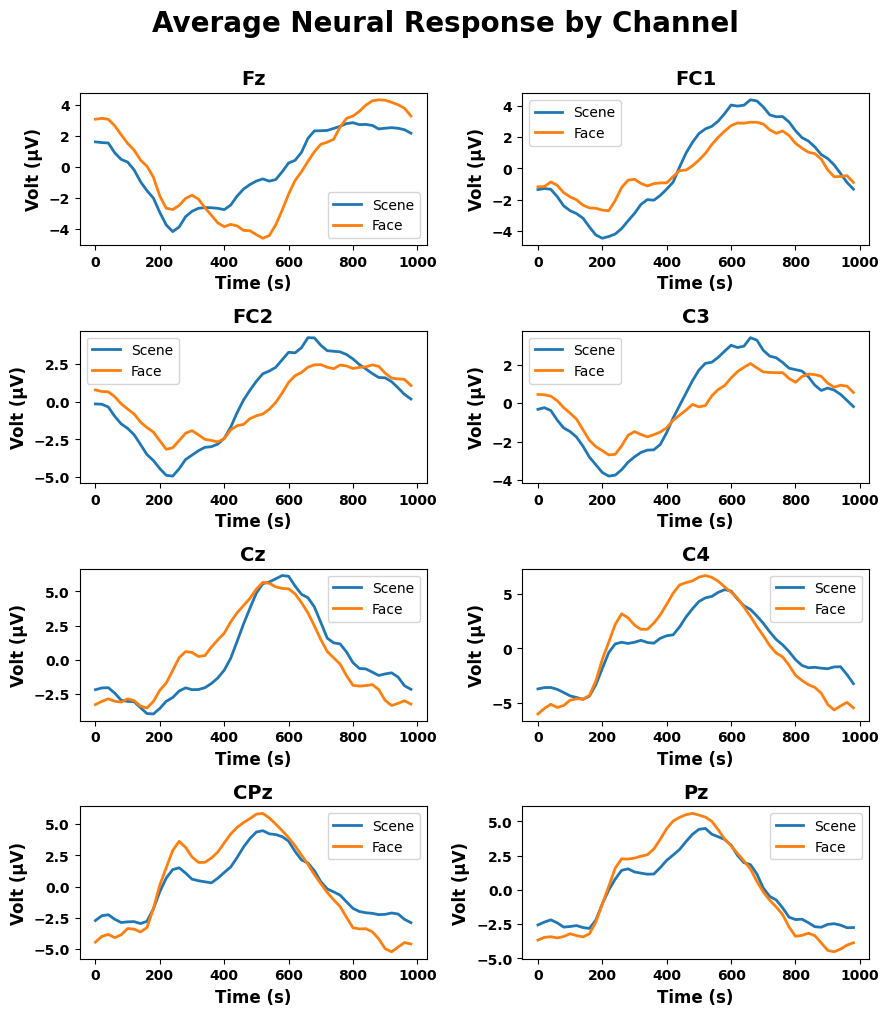

In [43]:
F_N=int(B_N/2)
S_N=int(B_N/2)
face_eeg_dada=face.reshape(F_N,39,50,5,9)
face_eeg_dada=face_eeg_dada[:,:,:,:,:8]
face_eeg_dada=face_eeg_dada.mean(axis=3)
face_eeg_dada=face_eeg_dada.mean(axis=1)
print(face_eeg_dada.shape)
face_mean=face_eeg_dada.mean(axis=0)
print(face_mean.shape)
scene_eeg_dada=scene.reshape(S_N,39,50,5,9)
scene_eeg_dada=scene_eeg_dada[:,:,:,:,:8]
scene_eeg_dada=scene_eeg_dada.mean(axis=3)
scene_eeg_dada=scene_eeg_dada.mean(axis=1)
print(scene_eeg_dada.shape)
scene_mean=scene_eeg_dada.mean(axis=0)
print(scene_mean.shape, type(scene_mean))





# base_eeg_dada=base.reshape(8,2,50,5,9)
# base_eeg_dada=base_eeg_dada[:,:,:,:,:8]
# base_eeg_dada=base_eeg_dada.mean(axis=3)
# base_eeg_dada=base_eeg_dada.mean(axis=1)
# print(base_eeg_dada.shape)
# base_mean=base_eeg_dada.mean(axis=0)
# print(base_mean.shape, type(base_mean))

 

time_list = []
channels_names = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']

for n in range(face_mean.shape[0]):
    time = (n*5)/(fs)*1000
    time_list.append(time)

plt.figure(figsize=(9,12))
plt.suptitle('Average Neural Response by Channel', y=1.002, fontsize=20, weight='bold') 

for channel in range(8):
    plt.subplot(5,2, channel + 1)  
    plt.plot(time_list, face_mean[:, channel], label=f'Scene', linewidth=2)
    plt.plot(time_list, scene_mean[:, channel], label=f'Face', linewidth=2)
    # plt.plot(time_list, base_mean[:, channel], label=f'Base', linewidth=1)
    plt.title(channels_names[channel], fontsize=14, weight='bold')  # Adding the channel name as the title with bold and bigger font
    
    # Bigger and bold x and y axis labels
    plt.xlabel('Time (s)', fontsize=12, weight='bold')               
    plt.ylabel('Volt (µV)', fontsize=12, weight='bold')      

    # Bigger and bold x and y axis tick labels
    plt.xticks(fontsize=10, weight='bold')
    plt.yticks(fontsize=10, weight='bold')

    plt.legend(fontsize=10)

plt.tight_layout()
plt.show()
                       

In [62]:
face_eeg=face.reshape(12,39,250,9)
face_eeg=face_eeg[:,:,:,:8]
face_eeg=face_eeg.mean(axis=1)

face_mean_=face_eeg.mean(axis=0)

scene_eeg=scene.reshape(12,39,250,9)
scene_eeg=scene_eeg[:,:,:,:8]
scene_eeg=scene_eeg.mean(axis=1)

scene_mean_=scene_eeg.mean(axis=0)
print(scene_mean_.shape, type(scene_mean_))

(250, 8) <class 'numpy.ndarray'>


In [44]:
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
     }

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)


In [45]:
mlp_data=denoised_reshaped.reshape(denoised_reshaped.shape[0], denoised_reshaped.shape[1]*denoised_reshaped.shape[2])
print(mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)


X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.1, random_state=42)


(936, 2000)
(936, 2000) (936,)


In [46]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,3)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


d:\11-software\Python3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2023-11-22 12:56:13,497] A new study created in memory with name: no-name-92e2abff-5ef9-4cc1-81fc-bf2d2664bbaf
[I 2023-11-22 12:56:15,890] Trial 0 finished with value: 0.7446808510638298 and parameters: {'n_layers': 1, 'n_units_layer0': 234, 'activation': 'relu', 'learning_rate_init': 0.07506948384362158, 'max_iter': 790}. Best is trial 0 with value: 0.7446808510638298.
[I 2023-11-22 12:56:23,050] Trial 1 finished with value: 0.6914893617021277 and parameters: {'n_layers': 3, 'n_units_layer0': 264, 'n_units_layer1': 390, 'n_units_layer2': 453, 'activation': 'identity', 'learning_rate_init': 0.010038050387877029, 'max_iter': 819}. Best is trial 0 with value: 0.7446808510638298.
[I 2023-11-22 12:56:26,528] Trial 2 finished with value: 0.7234

Number of finished trials:  70
Best trial:
  Value:  0.8085106382978723
  Params: 
    n_layers: 1
    n_units_layer0: 252
    activation: relu
    learning_rate_init: 0.003113387485218969
    max_iter: 812


In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)


# Predict using the training data
train_predictions = best_model.predict(X_train_mlp)

# Evaluate the model using training data
train_accuracy = accuracy_score(y_train_mlp, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Training Accuracy: 0.9964
Test Accuracy: 0.8085
